# Off-grid sensors

This example demonstrates how to use the band-limited interpolant implementation of sensors in jWave. This removes the staircasing effects that are observed when sensors are defined as binary masks.

In [1]:
import numpy as np
from jax import jit, grad
from jax import numpy as jnp
from matplotlib import pyplot as plt

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import Sensors, _circ_mask, BLISensors, Domain, Medium, TimeAxis
from jwave.utils import show_field

from functools import partial

The first section is identical to previous examples. Ee define the simulation domain, the medium in which the wave will propagate and the time axis.

In [2]:
Nx = 128
dx = 0.2e-3

domain = Domain((Nx, Nx), (dx, dx))
medium = Medium(domain=domain, sound_speed=1500.0)
time_axis = TimeAxis.from_medium(medium, cfl=0.3)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Next, we define the initial pressure distribution, which in our case is a series of circles. 

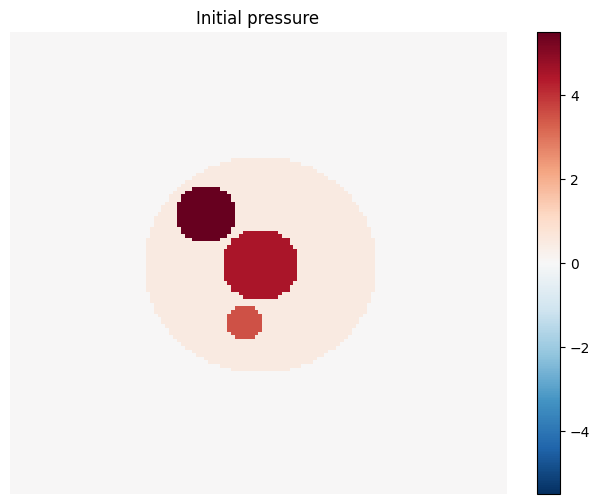

In [3]:
# Defining the initial pressure
N = domain.N
mask1 = _circ_mask(N, 16 * Nx / 256, (100 * Nx / 256, 100 * Nx / 256))
mask2 = _circ_mask(N, 10 * Nx / 256, (160 * Nx / 256, 120 * Nx / 256))
mask3 = _circ_mask(N, 20 * Nx / 256, (128 * Nx / 256, 128 * Nx / 256))
mask4 = _circ_mask(N, 60 * Nx / 256, (128 * Nx / 256, 128 * Nx / 256))
p0 = 5.0 * mask1 + 3.0 * mask2 + 4.0 * mask3 + 0.5 * mask4

p0 = 1.0 * jnp.expand_dims(p0, -1)
p0 = FourierSeries(p0, domain)

show_field(p0)
plt.title("Initial pressure")
plt.show()

Next, we define a series of sensors on a circle. We will compare the on-grid and off-grid sensor implementations so both are defined here.

In [4]:
num_sensors = 256
sensor_radius = 100 * Nx / 256

theta = np.linspace(0, 2 * np.pi, num_sensors, endpoint=False)
x = np.cos(theta) * sensor_radius + Nx / 2
y = np.sin(theta) * sensor_radius + Nx / 2

sensors_on_grid = Sensors(positions=(x.astype(int), y.astype(int)))
sensors_off_grid = BLISensors(positions=(x, y), n=domain.N)

We make a simulator that records both the on-grid measurements and the off-grid measurements, and compile it using the jit function.

In [5]:
def multi_sensors(*args):
    return {"On Grid": sensors_on_grid(*args), "Off Grid": sensors_off_grid(*args)}

def compiled_simulator(medium, p0, sensors):
    a = simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)
    return a

compiled_simulator_multi_sensors = jit(partial(compiled_simulator, sensors=multi_sensors))

Now we run the simulation and extract the sensor data from the off-grid sensors and the on-grid sensors.

In [6]:
sensors_data = compiled_simulator_multi_sensors(medium, p0)
off_grid_sensor_data = sensors_data["Off Grid"]
on_grid_sensor_data = sensors_data["On Grid"]

To compare the two sensor types, we plot their time series.

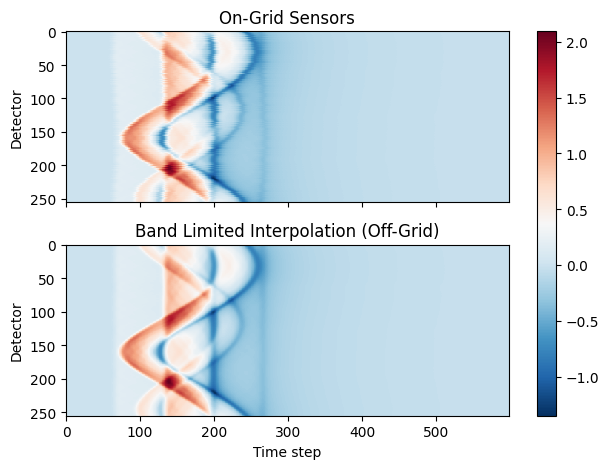

In [7]:
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True)

im = ax1.imshow(off_grid_sensor_data.T[0], aspect="auto", interpolation="none", cmap="RdBu_r")
ax2.imshow(on_grid_sensor_data.T[0], aspect="auto", interpolation="none", clim=im.get_clim(), cmap="RdBu_r")

ax1.set_title("Band Limited Interpolation (Off-Grid)")

ax1.set_xlabel("Time step")
ax1.set_ylabel("Detector")
ax2.set_ylabel("Detector")

ax2.set_title("On-Grid Sensors")
plt.tight_layout()
plt.colorbar(im, ax=[ax1, ax2])
plt.show()

## Gradient descent on sensor positions.

The beauty of the JAX implementation of j-Wave and the band limited interpolation is that it allows you to differentiate with respect to any parameter, including sensor position.

To illustrate that feature, we will use gradient descent to calculate the radius of the detectors.

First, we will define a loss function, for this we will use the mean square error. We differentiate that using the jax grad function and iteratively adjust the radius guess until it is close to the value defined above, 50.

In [8]:
@jit
def get_sensor_loss(sensor_radius):
    num_sensors = 256
    theta = jnp.linspace(0, 2 * np.pi, num_sensors, endpoint=False)
    x = jnp.cos(theta) * sensor_radius + Nx / 2
    y = jnp.sin(theta) * sensor_radius + Nx / 2
    
    s = BLISensors(positions=(x, y), n=domain.N)
    result_with_sensors = jit(compiled_simulator)(medium, p0, s)
    
    return jnp.mean((on_grid_sensor_data - result_with_sensors)**2)

We then do a basic gradient descent, updating the radius by a small step every time, converging on the true value, 50.

In [10]:
dlossdr = grad(get_sensor_loss)

r = 40.
step_size = 100
n_steps = 10
gradient = np.nan

for i in range(n_steps):
    loss = get_sensor_loss(r)
    print(f"Step {i}. Guess: R = {r:.1f}, Loss = {loss:.3f}, Gradient = {gradient:.3f}")
    gradient = dlossdr(r)
    
    r = r - gradient * step_size

loss = get_sensor_loss(r)
print(f"End: Guess: R = {r:.1f}, Loss = {loss:.3f}")

Step 0. Guess: R = 40.0, Loss = 0.170, Gradient = nan
Step 1. Guess: R = 41.6, Loss = 0.144, Gradient = -0.016
Step 2. Guess: R = 43.3, Loss = 0.114, Gradient = -0.017
Step 3. Guess: R = 45.1, Loss = 0.079, Gradient = -0.018
Step 4. Guess: R = 47.1, Loss = 0.040, Gradient = -0.020
Step 5. Guess: R = 49.1, Loss = 0.007, Gradient = -0.020
Step 6. Guess: R = 50.1, Loss = 0.002, Gradient = -0.010
Step 7. Guess: R = 49.9, Loss = 0.002, Gradient = 0.001
Step 8. Guess: R = 50.0, Loss = 0.002, Gradient = -0.000
Step 9. Guess: R = 50.0, Loss = 0.002, Gradient = 0.000
End: Guess: R = 50.0, Loss = 0.002
